In [1]:
# import packages
import pandas as pd
import numpy as np
import plotly.express as px
import os

In [3]:
# define desired directory path
#directory_path = "/Users/treypallace/Desktop/Fourth Year Fall 2023/ds 4002/Project_Data/linkedin"

# use os.chdir() to change the working directory
#os.chdir(directory_path)

# read in the data
job_postings_df = pd.read_csv("job_postings.csv")
job_skills_df = pd.read_csv("job_skills.csv")


### Join the job_postings_df with the job_skills_df

In [4]:
# merge data
df = job_postings_df.merge(job_skills_df, on='job_id',  how='left')

In [5]:
# select columns
df = df[['job_id', 'description', 'max_salary', 'med_salary', 'min_salary', 'pay_period', 'currency', 'work_type','compensation_type','skill_abr', 'location', 'title']]

In [5]:
# convert every salary to hourly pay period
def convert_to_hourly(row):
    if row['pay_period'] == 'YEARLY':
        if row['work_type'] in ['FULL_TIME', 'CONTRACT']:
            return row['min_salary'] / (40 * 52), row['max_salary'] / (40 * 52)
        elif row['work_type'] == 'PART_TIME':
            return row['min_salary'] / (20 * 52), row['max_salary'] / (20 * 52)
    elif row['pay_period'] == 'MONTHLY':
        if row['work_type'] in ['FULL_TIME', 'CONTRACT']:
            return row['min_salary'] * 12 / (40 * 52), row['max_salary'] * 12 / (40 * 52)
        elif row['work_type'] == 'PART_TIME':
            return row['min_salary'] * 12 / (20 * 52), row['max_salary'] * 12 / (20 * 52)
    else:
        return row['min_salary'], row['max_salary']

# Apply the function to the DataFrame using a lambda function
df[['min_salary', 'max_salary']] = df.apply(lambda row: convert_to_hourly(row), axis=1, result_type='expand')


In [6]:
# calculate average salary
df['avg_salary'] = (df['max_salary'] + df['min_salary']) / 2

In [7]:
nan_counts = df.isna().sum()
nan_counts

job_id                   0
description              2
max_salary           17903
med_salary           25826
min_salary           17903
pay_period           16069
currency             16069
work_type                0
compensation_type    16069
skill_abr              637
location                 0
title                    0
avg_salary           17903
dtype: int64

In [8]:
# filter to remove rows without descriptions or avg_salary
df = df.dropna(subset=['description', 'avg_salary'])

## Model Building: Frequency Count

In [9]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the WordNet lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(nltk.corpus.stopwords.words('english'))

# Function to tokenize a sentence into words
def sentence_to_wordlist(raw_sentence):
    clean_sentence = re.sub("[^a-zA-Z0-9]", " ", raw_sentence)
    tokens = nltk.word_tokenize(clean_sentence)
    return tokens

# Tokenize a description into a list of word lists and remove stopwords
def tokenize(description):
    stripped_description = description.strip()
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(stripped_description)

    tokenized_sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            tokens = sentence_to_wordlist(raw_sentence)
            tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
            tokenized_sentences.append(tokens)

    return tokenized_sentences

# Get Bag of Words (BOW) counts
def get_count_vectors(descriptions):
    vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 3), stop_words='english')
    count_vectors = vectorizer.fit_transform(descriptions)
    feature_names = vectorizer.get_feature_names_out()
    return feature_names, count_vectors

# Assuming you have a DataFrame 'df' with a 'description' column
feature_names_cv, count_vectors = get_count_vectors(df['description'])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Most Frequent Words before Extracting for Skills

In [ ]:
# Sum the counts of each word across all documents
word_counts = count_vectors.sum(axis=0)

# Convert the word counts to a list of (word, count) tuples
word_counts_tuples = [(word, count) for word, count in zip(feature_names_cv, word_counts.tolist()[0])]

# Sort the tuples by count in descending order
sorted_word_counts = sorted(word_counts_tuples, key=lambda x: x[1], reverse=True)

# Get the top N most frequent words (adjust N as needed)
top_N_words = 30  # Change this value to get a different number of top words
top_words = sorted_word_counts[:top_N_words]

# Print the top words with their counts
for word, count in top_words:
    print(f'{word}: {count}')


experience: 35388
work: 29388
team: 22440
skills: 17717
business: 17483
including: 16687
management: 14778
ability: 14377
job: 13689
position: 13343
benefits: 12549
time: 12439
company: 12306
years: 11944
support: 11742
required: 11501
data: 11372
role: 11211
new: 10669
development: 10483
customer: 10374
sales: 10043
knowledge: 9746
opportunity: 9675
working: 9610
project: 9339
information: 9179
range: 9096
related: 9009
status: 8561


## Extract for Skills - Named Entity Recognition


In [10]:
 !pip install skillNer
 !python -m spacy download en_core_web_lg

2023-09-24 21:58:54.592933: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-24 21:58:56.007769: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [11]:
# imports
import spacy
import en_core_web_lg
from spacy.matcher import PhraseMatcher

# import skill extractor
from skillNer.skill_extractor_class import SkillExtractor
from skillNer.general_params import SKILL_DB

# init params of skill extractor
nlp = en_core_web_lg.load()
# init skill extractor
skill_extractor = SkillExtractor(nlp, SKILL_DB, PhraseMatcher)

loading full_matcher ...
loading abv_matcher ...
loading full_uni_matcher ...
loading low_form_matcher ...
loading token_matcher ...


In [12]:
#tests a random job description
import random
job_description = df['description'].sample().values[0]

# Extract skills
annotations = skill_extractor.annotate(job_description)

skill_extractor.describe(annotations)

/usr/local/lib/python3.10/dist-packages/skillNer/utils.py:99: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  vec_similarity = token1.similarity(token2)


In [13]:
# Extract values from 'doc_node_value' and save them into a list
values_list = []
for item in annotations['results']['full_matches']:
    values_list.append(item['doc_node_value'])

# remove repeats
skills_list = list(set(values_list))

print(skills_list)

['problem solve', 'stakeholder engagement', 'decision make', 'job description', 'business administration', 'San', 'relationship building', 'fund development', 'grant writing', 'microsoft word', 'growth strategy', 'lifelong learning', 'self sufficiency', 'write communication', 'strategic decision make']


In [14]:
## ****takes a VERY long time to run, just import the extracted_skills.csv dataframe****
def extract_skills(description, row_index):
    try:
        # Extract skills
        annotations = skill_extractor.annotate(description)

        # Extract values from 'doc_node_value' and save them into a list
        values_list = []
        for item in annotations['results']['full_matches']:
            values_list.append(item['doc_node_value'])

        # Remove duplicates
        skills_list = list(set(values_list))

        return skills_list
    except Exception as e:
        # Handle any exceptions (e.g., if the extraction process fails)
        print(f"Error extracting skills from description at row {row_index}: {e}")
        return []

In [ ]:
#df4['skills_extracted'] = df4.apply(lambda row: extract_skills(row['description'], row.name), axis=1)

In [ ]:
# takes a VERY LONG time to run. Just import dataset
df['skills_extracted'] = df.apply(lambda row: extract_skills(row['description'], row.name), axis=1)

In [ ]:
empty_skills_df = skills_df[skills_df['skills_extracted'].apply(len) == 0].copy()

In [ ]:
final_df = df[df['skills_extracted'].apply(len) > 0]

In [ ]:
final_df.to_csv('extracted_skills.csv', index=False)

## Most Frequent Skills after NER

In [6]:
extracted_skills_df = pd.read_csv("extracted_skills.csv")

In [7]:
# flatten the lists of skills into a Series
flattened_skills = extracted_skills_df["skills_extracted"].explode()

# get word frequencies
word_counts = flattened_skills.value_counts().reset_index()

# rename the columns
word_counts.columns = ['Word', 'Frequency']

# print the top N most frequent words (e.g., top 10)
top_N = 30
print(word_counts.head(top_N))


                                                 Word  Frequency
0   ['resource planning', 'industry practice', 'li...        108
1   ['customer service', 'diversity and inclusion'...         55
2   ['write communication', 'call center', 'geneti...         38
3   ['persuasive communication', 'cost reduction',...         30
4   ['social engineering', 'vulnerability manageme...         28
5                              ['career development']         26
6   ['com', 'commercial insurance', 'continuous im...         24
7   ['operation research', 'google ad', 'google da...         24
8   ['mobile app', 'team build', 'act', 'microsoft...         23
9            ['job description', 'financial control']         21
10                                            ['com']         21
11  ['com', 'OSHA', 'supply chain', 'html', 'work ...         20
12  ['sale engineering', 'business process', 'comp...         18
13  ['predictive analytic', 'program management', ...         18
14  ['team management', '

In [8]:
extracted_skills_df.head()

,job_id,description,max_salary,med_salary,min_salary,pay_period,currency,work_type,compensation_type,skill_abr,location,title,avg_salary,skills_extracted
0,903408693,Provide clerical and administrative support to...,20.192308,NaN,17.788462,YEARLY,USD,FULL_TIME,BASE_SALARY,ADM,"Albany, GA",Office Associate,18.990385,"['data entry', 'customer experience', 'manufac..."
1,1029078768,United Staffing Solutions is partnering with o...,50.000000,NaN,50.000000,HOURLY,USD,PART_TIME,BASE_SALARY,HCPR,"Muskegon, MI",Registered Nurse (RN) Vaccinator,50.000000,"['com', 'reach']"
2,1535492735,We are looking for a responsible Administrativ...,20.000000,NaN,18.000000,HOURLY,USD,PART_TIME,BASE_SALARY,ADM,"Ocoee, FL",Administrative Assistant,19.000000,"['problem solve', 'administrative skill', 'wri..."
3,1657978824,"REMOTE WORK FROM HOME $1,000 TO $10,000 COMMIS...",69.230769,NaN,69.230769,MONTHLY,USD,CONTRACT,BASE_SALARY,OTHR,"Texas, United States","REMOTE STEEL BUILDING SALES MAKE $1,000 TO $30...",69.230769,"['com', 'facebook ad']"
4,2148434586,Invitation Homes is a fast-paced evolving publ...,82.200000,NaN,47.423077,YEARLY,USD,FULL_TIME,BASE_SALARY,IT,"New Hampshire, United States","Manager, Salesforce Platform",64.811538,"['business process', 'lightning web component'..."


In [9]:
justSkills = extracted_skills_df['skills_extracted']
skillsAndCounts = {}
idx = 0

for skillList in justSkills:
  skillList = skillList.replace('[\'', '')
  skillList = skillList.replace('\']', '')
  skillListUpdated = skillList.split('\', \'')
  #print(skillListUpdated)

  for skill in skillListUpdated:
    if skillsAndCounts.get(skill) == None:
      #print(extracted_skills_df.iloc[idx]['avg_salary'])
      content = [1, extracted_skills_df.iloc[idx]['avg_salary']]
      skillsAndCounts.update({skill: content})
    else:
      skillsAndCounts[skill][0] = skillsAndCounts.get(skill)[0] + 1
      skillsAndCounts[skill][1] = skillsAndCounts.get(skill)[1] + extracted_skills_df.iloc[idx]['avg_salary']

  idx = idx + 1

print(skillsAndCounts)

{'data entry': [87, 2679.3401923076917], 'customer experience': [442, 20805.92145913462], 'manufacturing process': [107, 5429.880673076921], 'com': [2243, 115257.30182932675], 'reach': [709, 32326.462045673074], 'problem solve': [1557, 80281.59699759573], 'administrative skill': [12, 454.17764423076926], 'write communication': [1013, 48231.699223557844], 'facebook ad': [3, 177.40384615384616], 'business process': [309, 19580.294129807702], 'lightning web component': [6, 388.8692307692308], 'management process': [142, 8862.482163461533], 'business logic': [12, 872.8716346153847], 'salesforce com': [49, 2224.976817307692], 'case': [325, 14987.424497596136], 'release note': [10, 581.8692307692309], 'user story': [53, 3622.3764423076937], 'experience design': [189, 8645.459375], 'storage management': [12, 717.0349182692308], 'change management': [130, 8256.018774038464], 'data file': [7, 449.8692307692308], 'user interface': [75, 4822.363461538462], 'production support': [40, 2458.76413461

In [10]:
for skill in skillsAndCounts:
  skillsAndCounts[skill][1] = skillsAndCounts[skill][1] / skillsAndCounts[skill][0]

print(skillsAndCounts)

{'data entry': [87, 30.797013704686112], 'customer experience': [442, 47.07222049577968], 'manufacturing process': [107, 50.74654834651328], 'com': [2243, 51.38533296002085], 'reach': [709, 45.59444576258544], 'problem solve': [1557, 51.561719330504644], 'administrative skill': [12, 37.84813701923077], 'write communication': [1013, 47.612733685644464], 'facebook ad': [3, 59.13461538461539], 'business process': [309, 63.36664766928059], 'lightning web component': [6, 64.81153846153846], 'management process': [142, 62.41184622156009], 'business logic': [12, 72.73930288461538], 'salesforce com': [49, 45.40769014913657], 'case': [325, 46.115152300295804], 'release note': [10, 58.18692307692309], 'user story': [53, 68.34672532656026], 'experience design': [189, 45.743171296296296], 'storage management': [12, 59.75290985576924], 'change management': [130, 63.507836723372804], 'data file': [7, 64.26703296703297], 'user interface': [75, 64.2981794871795], 'production support': [40, 61.46910336

In [18]:
dfUpdated = pd.DataFrame.from_dict(skillsAndCounts, orient='index')
dfUpdated = dfUpdated.rename(columns={0: "Frequency", 1: "Average_Salary"})
dfUpdated

,Frequency,Average_Salary
data entry,87,30.797014
customer experience,442,47.072220
manufacturing process,107,50.746548
com,2243,51.385333
reach,709,45.594446
...,...,...
track system,1,45.960000
inventory turnover,1,48.076923
complex network,2,53.846154
computer assist translation,3,47.379808


<Axes: xlabel='Frequency'>

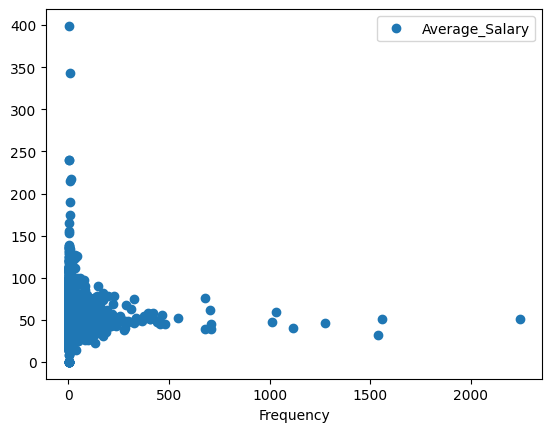

In [20]:
dfUpdated.plot(x='Frequency', y='Average_Salary', style='o')

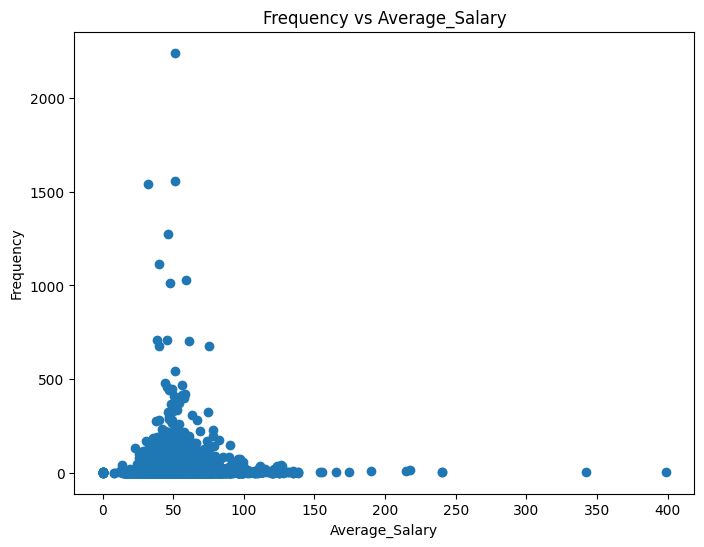

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(dfUpdated['Average_Salary'], dfUpdated['Frequency'], linestyle='None', marker='o')
plt.title('Frequency vs Average_Salary')
plt.xlabel('Average_Salary')
plt.ylabel('Frequency')
plt.savefig('FrequencyVSAverageSalary')
plt.show()

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dfUpdated['Average_Salary'],
                                                    dfUpdated['Frequency'],
                                                    random_state=104,
                                                    test_size=0.25,
                                                    shuffle=True)

model = LinearRegression()
X_train = X_train.values
averageSalUpdated = model.fit(X_train.reshape(-1, 1), y_train)

r_sq = model.score(X_train.reshape(-1, 1), y_train)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

coefficient of determination: 3.6088154234614755e-05
intercept: 16.91727967224142
slope: [0.01646539]


In [43]:
import numpy as np

X_test = X_test.values.reshape(-1, 1)

y_pred = model.predict(X_test)
print(y_pred)
print(y_test)

[17.1160631  17.43910596 17.12968719 ... 17.84452667 17.37831066
 17.41204678]
business architecture                  7
register representative                5
Mops                                   3
FICON                                  1
patient advocacy                       2
                                      ..
personally identifiable information    3
wastewater treatment plant             5
wan technology                         4
roll stock                             2
spatial analysis                       6
Name: Frequency, Length: 1189, dtype: int64


In [45]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, y_pred)
print(rmse)

9517.313851736024
